In [65]:
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import statsmodels.formula.api as smf
import sklearn
import folium
from sklearn import linear_model
from sklearn.preprocessing import LabelBinarizer
import econml
from sklearn.model_selection import train_test_split
from doubleml import DoubleMLData
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from doubleml import DoubleMLPLR

Data source is from Bayes package in R.

Documentation can be found on https://cran.r-project.org/web/packages/bayesm/bayesm.pdf.

Source <br>
Alan L. Montgomery (1997), "Creating Micro-Marketing Pricing Strategies Using Supermarket
Scanner Data," Marketing Science 16(4) 315–337.

References </br>
Chapter 5, Bayesian Statistics and Marketing by Rossi, Allenby, and McCulloch

### Question: how does the previous week's price affect this week's quantities sold?

According to [Economic Research Service of U.S Department of Agriculture](https://www.ers.usda.gov/data-products/chart-gallery/gallery/chart-detail/?chartId=58322#:~:text=Bananas%20(13.4%20pounds%20per%20person,gallons)%20remained%20America's%20favorite%20juice.), orange juice is America's favorite juice. Almost 50% of all juice consumed by Americans is ornage juice. The goal of this report is analyzing supermarket scanner data supports this claim. If Americans indeed love orange juice, the elasticitiy should be more inelastic. i.e. price increase should not stop Americans from buying orange juices!

# Data cleaning

In [66]:
sales_df = pd.read_csv('data_/sales.csv')
store_df = pd.read_csv('data_/store.csv')

In [67]:
sales_df.shape

(106139, 19)

In [68]:
store_df.shape

(83, 12)

In [69]:
sales_df.head()

,store,brand,week,logmove,constant,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,deal,feat,profit
0,2,1,40,9.018695,1,0.060469,0.060497,0.042031,0.029531,0.049531,0.053021,0.038906,0.041406,0.028906,0.024844,0.038984,1,0.0,37.992326
1,2,1,46,8.723231,1,0.060469,0.060312,0.045156,0.046719,0.049531,0.047813,0.045781,0.027969,0.042969,0.042031,0.038984,0,0.0,30.126667
2,2,1,47,8.253228,1,0.060469,0.060312,0.045156,0.046719,0.037344,0.053021,0.045781,0.041406,0.048125,0.032656,0.038984,0,0.0,30.000000
3,2,1,48,8.987197,1,0.060469,0.060312,0.049844,0.037344,0.049531,0.053021,0.045781,0.041406,0.042344,0.032656,0.038984,0,0.0,29.950000
4,2,1,50,9.093357,1,0.060469,0.060312,0.043594,0.031094,0.049531,0.053021,0.046648,0.041406,0.042344,0.032656,0.038203,0,0.0,29.920000


In [70]:
store_df.head()

,STORE,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,2,0.232865,0.248935,0.114280,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.927280,0.376927
1,5,0.117368,0.321226,0.053875,10.922371,0.103092,0.410568,0.535883,3.801998,0.681818,1.600573,0.736307
2,8,0.252394,0.095173,0.035243,10.597010,0.131750,0.283075,0.054227,2.636333,1.500000,2.905384,0.641016
3,9,0.269119,0.222172,0.032619,10.787152,0.096830,0.358995,0.505747,1.103279,0.666667,1.820474,0.441268
4,12,0.178341,0.253413,0.380698,9.996659,0.057212,0.390942,0.386628,9.198734,1.111111,0.839303,0.105999


In [71]:
# Join the tables by store id
df = pd.merge(sales_df,store_df,left_on='store', right_on='STORE',how='left')

In [72]:
df.shape

(106139, 31)

In [73]:
df = df.drop(columns=['constant'])

In [74]:
v = df.filter(like='price').columns.tolist()
other_vars = df.columns.difference(v)
result = df.melt(id_vars=other_vars, value_vars=v,value_name='price')
df = result

Each variables are defined as: <br>
store: store number <br>
brand: brand indicator <br>
week: week number <br>
logmove: log of the number of units sold <br>
price#: price of brand # <br>
deal: in-store coupon activity <br>
feature: whether there was feature advertisement for the brand at the store # on the week. <br>
profit: profit of the juice <br>

AGE60: percentage of the population that is aged 60 or older <br>
EDUC: percentage of the population that has a college degree <br>
ETHNIC: percent of the population that is black or Hispanic <br>
INCOME: median income <br>
HHLARGE: percentage of households with 5 or more persons <br>
WORKWOM: percentage of women with full-time jobs <br>
HVAL150: percentage of households worth more than $150,000 <br>
SSTRDIST: distance to the nearest warehouse store <br>
SSTRVOL: ratio of sales of this store to the nearest warehouse store <br>
CPDIST5: average distance in miles to the nearest 5 supermarkets <br>
CPWVOL5: ratio of sales of this store to the average of the nearest five stores <br>


Each price variables are defined as:

1 Tropicana Premium 64 oz </br>
2 Tropicana Premium 96 oz </br>
3 Florida’s Natural 64 oz </br>
4 Tropicana 64 oz </br>
5 Minute Maid 64 oz </br>
6 Minute Maid 96 oz </br>
7 Citrus Hill 64 oz </br>
8 Tree Fresh 64 oz </br>
9 Florida Gold 64 oz </br>
10 Dominicks 64 oz </br>
11 Dominicks 128 oz </br>

Exact product type is unnecessary for the goal of this report, so the wide price data will be pivoted to long price data and the brand will be recorded in a seperate column. 

In [75]:
# merge brands and change brand integer label to string
b_name = {
    'Tropicana': [1, 2, 4], 
    'Florida_natural': [3], 
    'Minute_maid': [5, 6], 
    'Citrus_hill': [7], 
    'Tree_fresh': [8], 
    'Florida_gold': [9], 
    'Dominicks': [10,11]}
b_size = {
    64: [1, 3, 4, 5, 7, 8, 9, 10], 
    96: [2, 6], 
    128: [11]}
df['new_brand'] = df.brand.map({item: k for k, v in b_name.items() for item in v})
df['new_brand'] = df['new_brand'].astype('string')
df['size'] = df.brand.map({item: k for k, v in b_size.items() for item in v})
df = df.drop(['brand', 'variable'],axis=1)
df = df.rename({'new_brand': 'brand'}, axis=1)

In [76]:
df.dtypes

AGE60       float64
CPDIST5     float64
CPWVOL5     float64
EDUC        float64
ETHNIC      float64
HHLARGE     float64
HVAL150     float64
INCOME      float64
SSTRDIST    float64
SSTRVOL     float64
STORE         int64
WORKWOM     float64
deal          int64
feat        float64
logmove     float64
profit      float64
store         int64
week          int64
price       float64
brand        string
size          int64
dtype: object

In [77]:
(df == 0).any()

AGE60       False
CPDIST5     False
CPWVOL5     False
EDUC        False
ETHNIC      False
HHLARGE     False
HVAL150     False
INCOME      False
SSTRDIST    False
SSTRVOL     False
STORE       False
WORKWOM     False
deal         True
feat         True
logmove     False
profit       True
store       False
week        False
price       False
brand       False
size        False
dtype: bool

In [78]:
(df.select_dtypes(include=[np.number]) <= 0).any()

AGE60       False
CPDIST5     False
CPWVOL5     False
EDUC        False
ETHNIC      False
HHLARGE     False
HVAL150     False
INCOME      False
SSTRDIST    False
SSTRVOL     False
STORE       False
WORKWOM     False
deal         True
feat         True
logmove     False
profit       True
store       False
week        False
price       False
size        False
dtype: bool

There is no negative or numbers that does not make sense.

In [79]:
df.isna().sum()

AGE60       0
CPDIST5     0
CPWVOL5     0
EDUC        0
ETHNIC      0
HHLARGE     0
HVAL150     0
INCOME      0
SSTRDIST    0
SSTRVOL     0
STORE       0
WORKWOM     0
deal        0
feat        0
logmove     0
profit      0
store       0
week        0
price       0
brand       0
size        0
dtype: int64

There is no missing values.

In [80]:
# change price to log price
df['price'] = df['price'].apply(np.log)

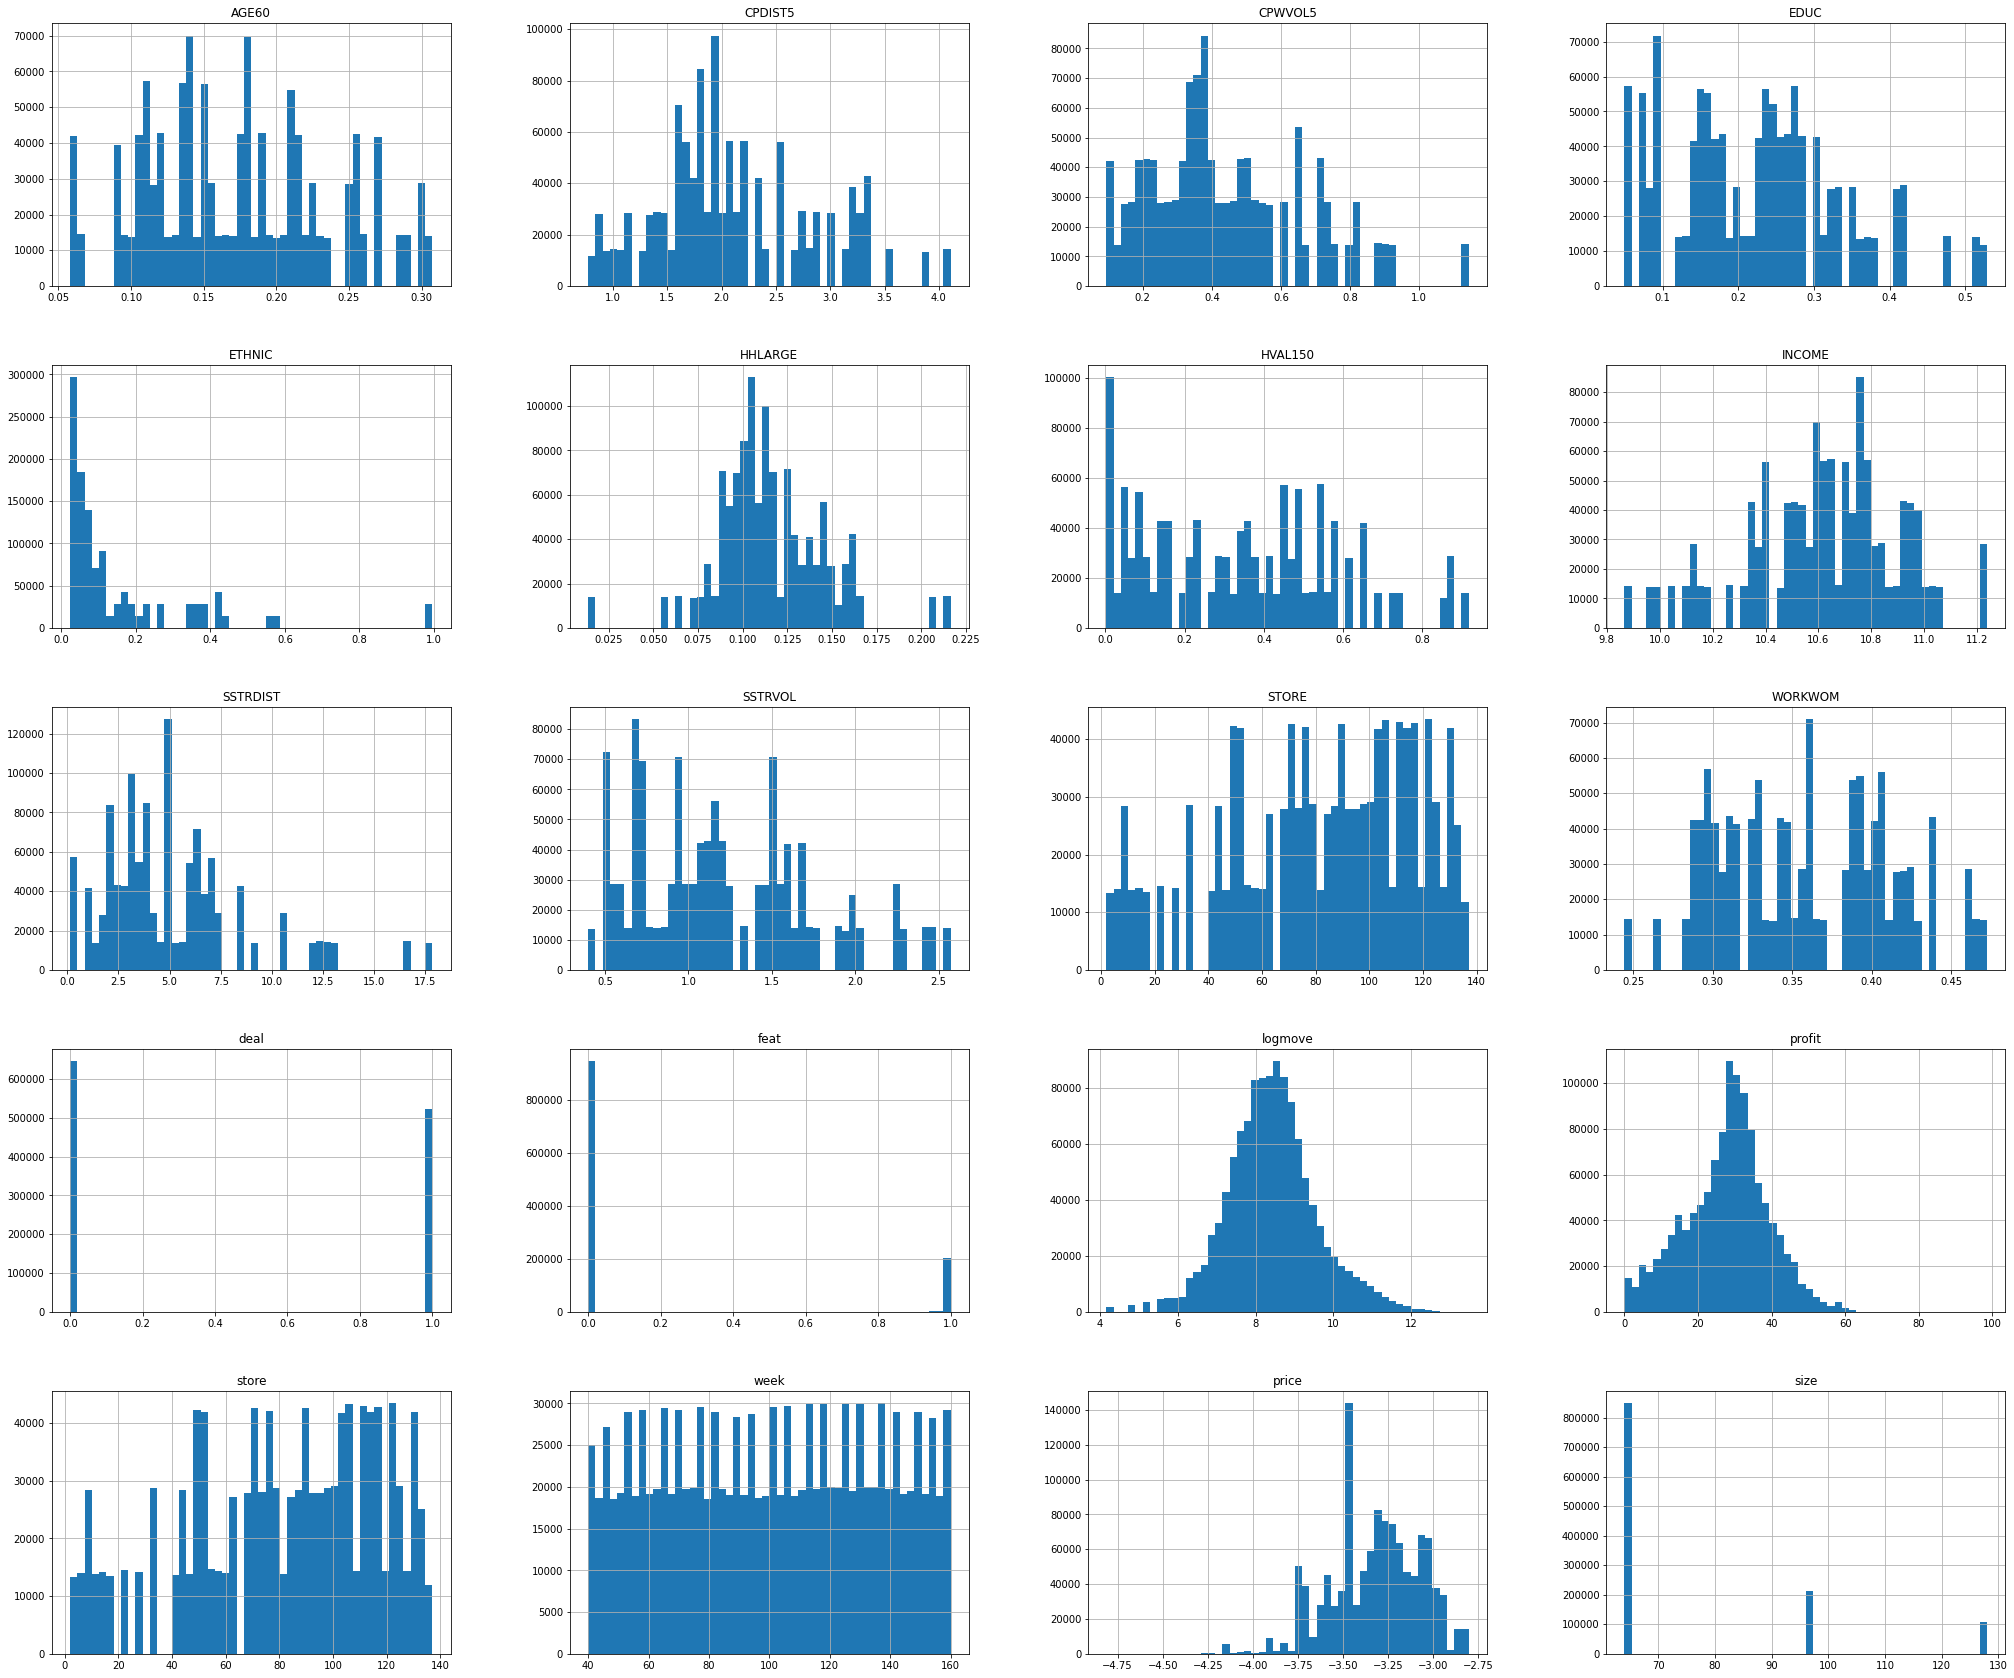

In [81]:
num_df = df.select_dtypes(include=[np.number])
num_df.hist(figsize = (35,30), bins = 50)
plt.show()

The variable of interest is log price and the distribution looks similar, so price will be replaced with log(price)

In [82]:
# lagged_df = df.sort_values('week') 
# price_start = lagged_df.columns.get_loc("price1")
# price_end = lagged_df.columns.get_loc("price11")+1
# for i in range(price_start, price_end):
#     var = 'lag_' + df.columns[i]
#     lagged_df[var] = df.groupby(["store", "brand"])[df.columns[i]].shift(1)
    
# lagged_df = lagged_df.dropna(subset=['lag_price1'])
# df = lagged_df

The final data looks like the following:

In [83]:
df.sample(5)

,AGE60,CPDIST5,CPWVOL5,EDUC,ETHNIC,HHLARGE,HVAL150,INCOME,SSTRDIST,SSTRVOL,...,WORKWOM,deal,feat,logmove,profit,store,week,price,brand,size
490283,0.249201,3.133177,0.381569,0.051703,0.164964,0.125409,0.009843,10.573596,6.230357,1.500000,...,0.299584,1,1.0,10.241102,17.788418,98,134,-3.470748,Minute_maid,64
359101,0.257451,3.228630,0.183188,0.073054,0.109213,0.135341,0.005144,10.614966,2.584605,1.500000,...,0.292748,1,1.0,10.117308,29.680000,73,106,-3.634155,Dominicks,64
497772,0.175542,3.354377,0.520134,0.094236,0.365411,0.159840,0.074419,10.414393,4.037829,0.960000,...,0.360890,1,0.0,7.103322,26.985789,105,123,-3.246600,Florida_natural,64
1097674,0.190236,3.527768,0.367773,0.165670,0.162861,0.110543,0.049271,10.412351,3.909329,0.500000,...,0.327729,0,0.0,8.850231,12.227293,70,138,-3.756757,Minute_maid,64
975253,0.097922,2.198071,0.904417,0.303260,0.099492,0.078487,0.303356,10.756029,4.650687,1.615385,...,0.459683,1,0.0,7.249926,17.740000,48,65,-3.374982,Tree_fresh,64


In [84]:
df.dtypes

AGE60       float64
CPDIST5     float64
CPWVOL5     float64
EDUC        float64
ETHNIC      float64
HHLARGE     float64
HVAL150     float64
INCOME      float64
SSTRDIST    float64
SSTRVOL     float64
STORE         int64
WORKWOM     float64
deal          int64
feat        float64
logmove     float64
profit      float64
store         int64
week          int64
price       float64
brand        string
size          int64
dtype: object

In [85]:
df.describe()

,AGE60,CPDIST5,CPWVOL5,EDUC,ETHNIC,HHLARGE,HVAL150,INCOME,SSTRDIST,SSTRVOL,STORE,WORKWOM,deal,feat,logmove,profit,store,week,price,size
count,1.167529e+06,1.167529e+06,1.167529e+06,1.167529e+06,1.167529e+06,1.167529e+06,1.167529e+06,1.167529e+06,1.167529e+06,1.167529e+06,1.167529e+06,1.167529e+06,1.167529e+06,1.167529e+06,1.167529e+06,1.167529e+06,1.167529e+06,1.167529e+06,1.167529e+06,1.167529e+06
mean,1.731300e-01,2.120359e+00,4.389143e-01,2.252196e-01,1.555569e-01,1.156024e-01,3.437659e-01,1.061673e+01,5.097274e+00,1.207317e+00,8.088351e+01,3.591779e-01,4.469987e-01,1.840806e-01,8.417476e+00,2.781475e+01,8.088351e+01,1.004599e+02,-3.322046e+00,7.563636e+01
std,6.187079e-02,7.298154e-01,2.192443e-01,1.099432e-01,1.875777e-01,3.016750e-02,2.390244e-01,2.823089e-01,3.472327e+00,5.265193e-01,3.557591e+01,5.267182e-02,4.971831e-01,3.848602e-01,1.141366e+00,1.128088e+01,3.557591e+01,3.469173e+01,2.507493e-01,2.057039e+01
min,5.805397e-02,7.725297e-01,9.456175e-02,4.955029e-02,2.424657e-02,1.350636e-02,2.509410e-03,9.867083e+00,1.320968e-01,4.000000e-01,2.000000e+00,2.444627e-01,0.000000e+00,0.000000e+00,4.158883e+00,0.000000e+00,2.000000e+00,4.000000e+01,-4.812810e+00,6.400000e+01
25%,1.221000e-01,1.626192e+00,2.716730e-01,1.459849e-01,4.191024e-02,9.793763e-02,1.234857e-01,1.045608e+01,2.767046e+00,7.272727e-01,5.300000e+01,3.126357e-01,0.000000e+00,0.000000e+00,7.699842e+00,2.048600e+01,5.300000e+01,7.000000e+01,-3.470748e+00,6.400000e+01
50%,1.706548e-01,1.963412e+00,3.832268e-01,2.293904e-01,7.465643e-02,1.112212e-01,3.461538e-01,1.063533e+01,4.650687e+00,1.115385e+00,8.600000e+01,3.556351e-01,0.000000e+00,0.000000e+00,8.392990e+00,2.909000e+01,8.600000e+01,1.010000e+02,-3.287590e+00,6.400000e+01
75%,2.139493e-01,2.533672e+00,5.602403e-01,2.843947e-01,1.877609e-01,1.351677e-01,5.283129e-01,1.079696e+01,6.650602e+00,1.538462e+00,1.110000e+02,4.023132e-01,1.000000e+00,0.000000e+00,9.049232e+00,3.480263e+01,1.110000e+02,1.300000e+02,-3.132841e+00,9.600000e+01
max,3.073979e-01,4.107902e+00,1.143367e+00,5.283620e-01,9.956908e-01,2.163543e-01,9.166995e-01,1.123620e+01,1.785595e+01,2.571429e+00,1.370000e+02,4.723083e-01,1.000000e+00,1.000000e+00,1.348202e+01,9.851000e+01,1.370000e+02,1.600000e+02,-2.802844e+00,1.280000e+02


## Exploratory Analysis

Text(0.5, 1.0, 'Total Profit per Brand')

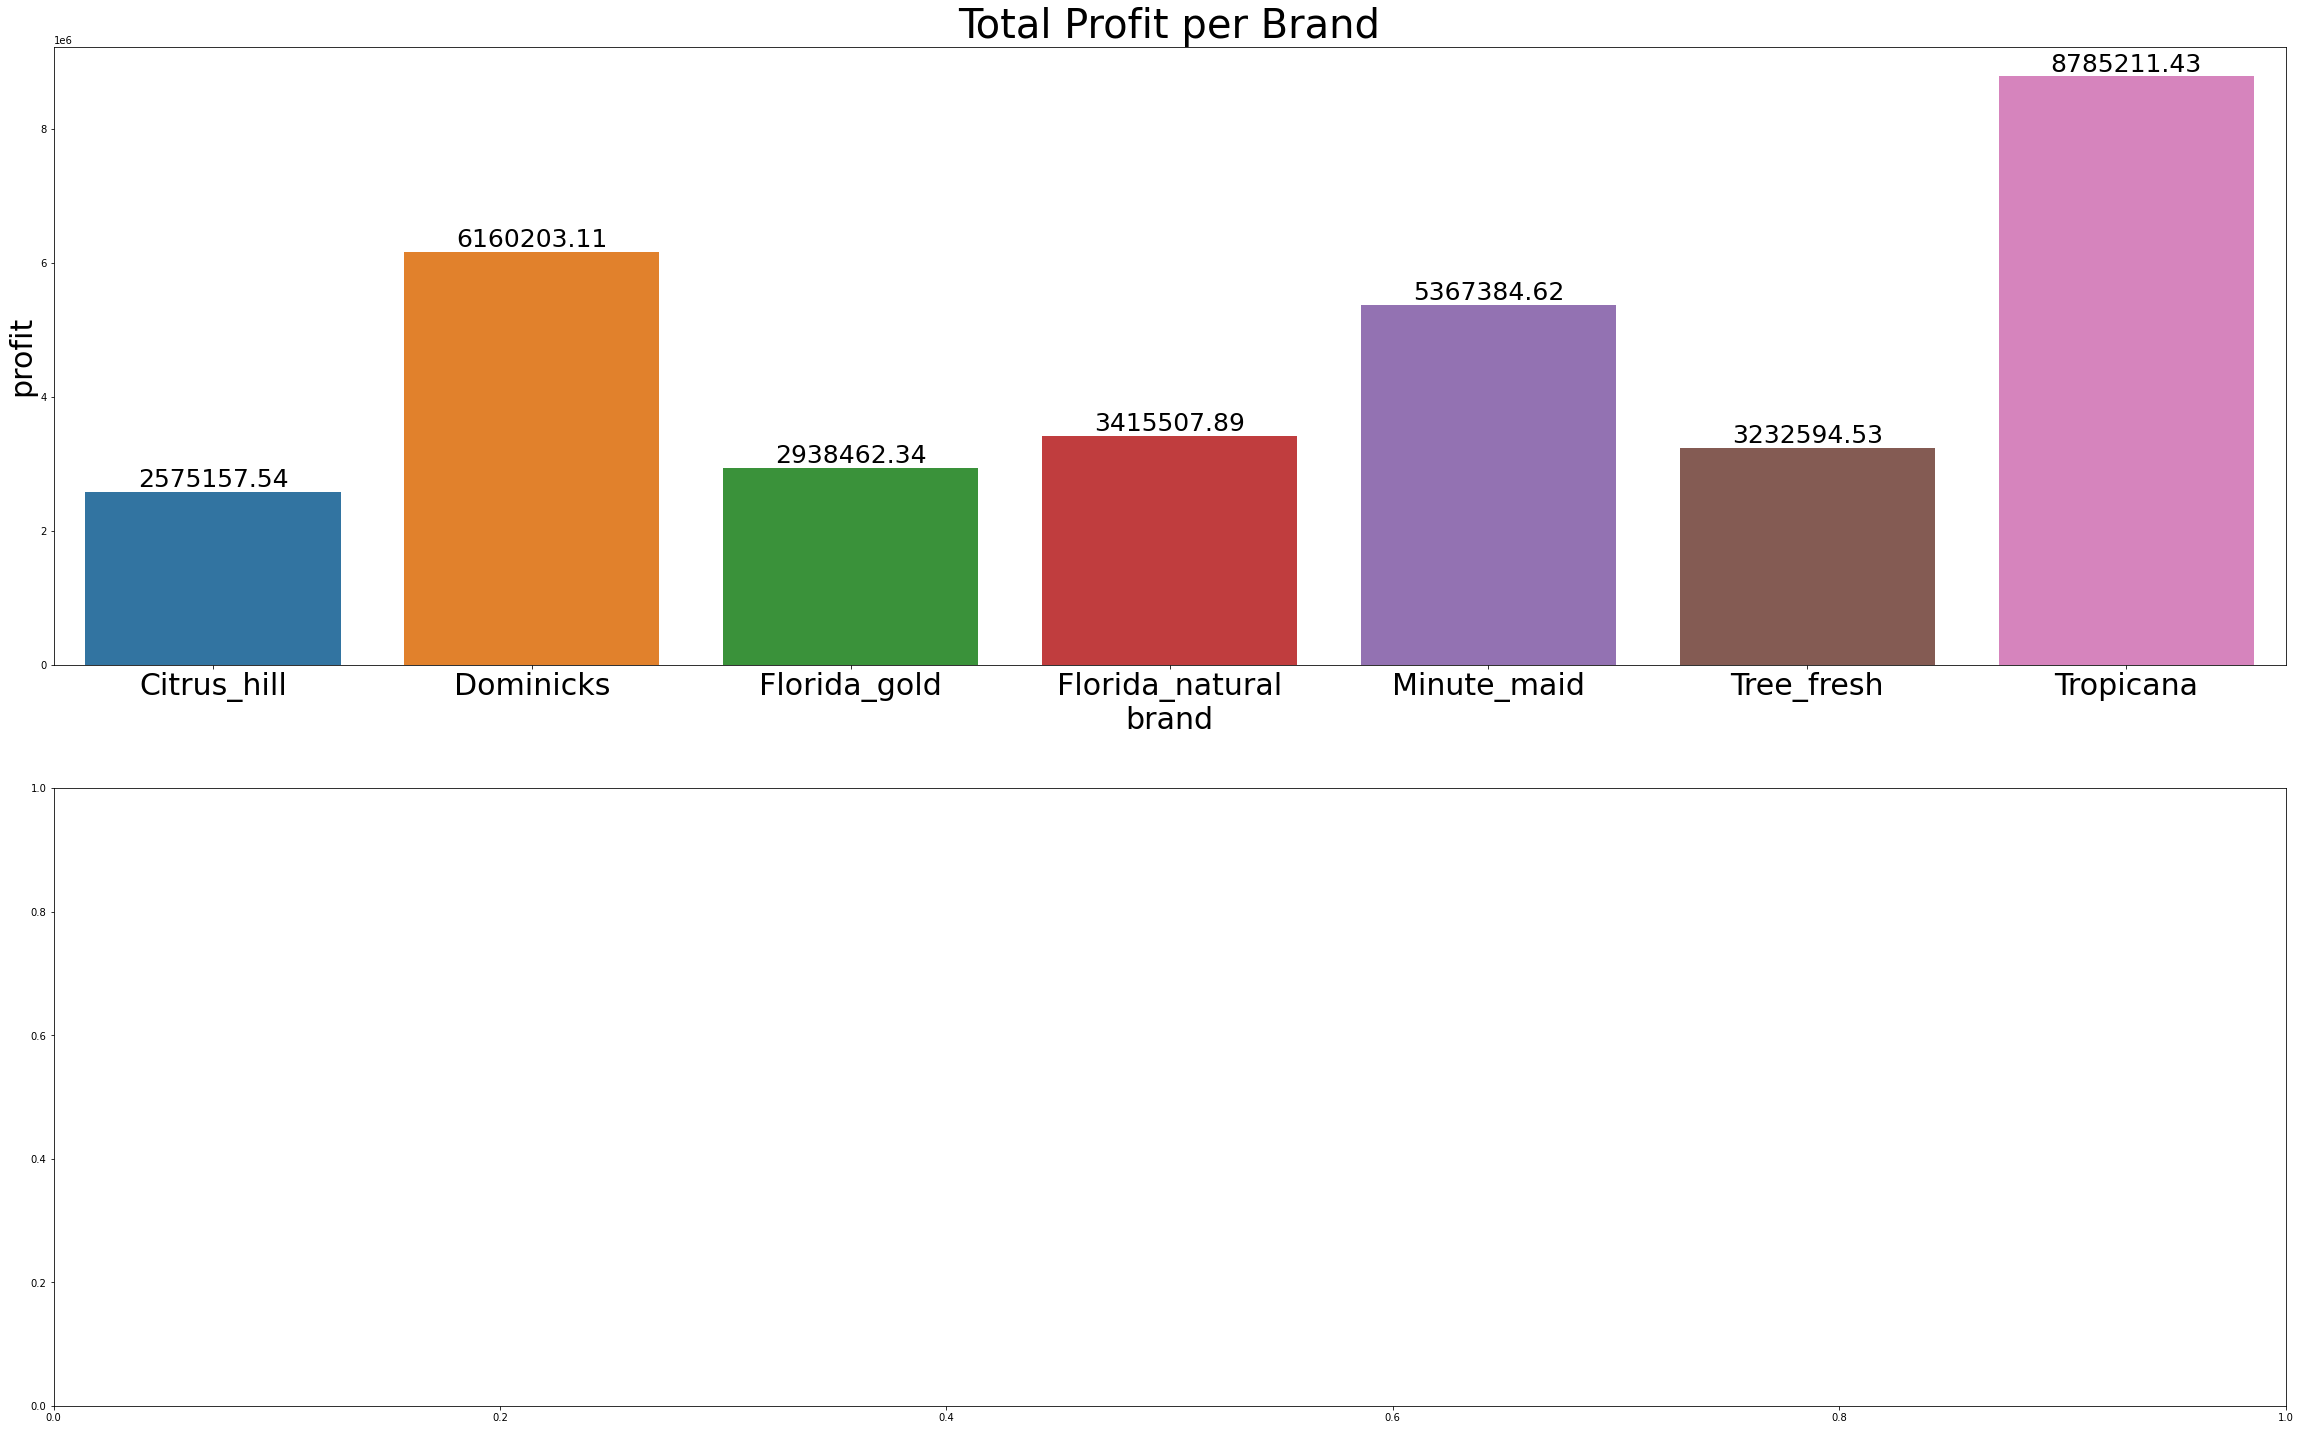

In [116]:
# Quantity per month
temp_data = df.groupby(['brand']).sum().reset_index()
fig, axes = plt.subplots(2, 1, figsize = (40,25))

sns.barplot(x='brand', y='profit', data=temp_data, ax=axes[0])
axes[0].set_xlabel(axes[0].get_xlabel(), size=30)
axes[0].set_ylabel(axes[0].get_ylabel(), size=30)
axes[0].set_xticklabels(axes[0].get_xticklabels(), size=30)
axes[0].bar_label(axes[0].containers[0], fmt='%.2f', size=25)
axes[0].set_title('Total Profit per Brand', size= 40)

sns.barplot(x='brand', y='logmove', data=temp_data, ax=axes[1])
axes[1].set_xlabel(axes[1].get_xlabel(), size=30)
axes[1].set_ylabel(axes[1].get_ylabel(), size=30)
axes[1].set_xticklabels(axes[1].get_xticklabels(), size=30)
axes[1].bar_label(axes[1].containers[0], fmt='%.2f', size=25)
axes[1].set_title('Total Quantity Sold per Brand', size= 40)

#### What brand is sold the most?

In [87]:
mock_data = pd.DataFrame({'week': [1,2],'brand': ['A', 'B'], 'logmove': [3, 4], 'profit':[4,8]})
mock_data.describe().shape

(8, 3)

In [88]:
df.groupby('brand').sum()[['logmove', 'profit']].sort_values('logmove', ascending=False)

,logmove,profit
brand,,
Tropicana,2.839746e+06,8.785211e+06
Dominicks,1.908864e+06,6.160203e+06
Minute_maid,1.858234e+06,5.367385e+06
Citrus_hill,8.505525e+05,2.575158e+06
Florida_natural,8.119214e+05,3.415508e+06
Tree_fresh,8.001189e+05,3.232595e+06
Florida_gold,7.582106e+05,2.938462e+06


In [89]:
df.groupby('brand').sum()[['logmove', 'profit']].sort_values('logmove', ascending=False)

,logmove,profit
brand,,
Tropicana,2.839746e+06,8.785211e+06
Dominicks,1.908864e+06,6.160203e+06
Minute_maid,1.858234e+06,5.367385e+06
Citrus_hill,8.505525e+05,2.575158e+06
Florida_natural,8.119214e+05,3.415508e+06
Tree_fresh,8.001189e+05,3.232595e+06
Florida_gold,7.582106e+05,2.938462e+06


In terms of quantities sold, Tropicana is sold most. Tropicana also had the largest profit. 

#### Timeseries of sales

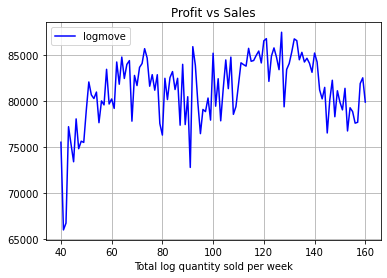

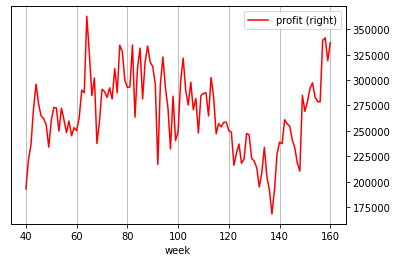

In [127]:
q_series=df.groupby('week').sum()[['logmove']]
q_series.plot(color='blue', grid=True)
plt.title("Sales over time")

p_series = df.groupby('week').sum()[['profit']]
p_series.plot(color='red',grid=True, secondary_y=True)
plt.show()

Week 120 - 140 is interesting because the quantity sold was at the peak, but the profit  was at the lowest. It could be that there were lots of sales during this period. Since orange juice is perishable good, the most likely scenario is that the stores expected the sales to increase and ordered lots of orange juice, but did not sell as much as expected. There could had been a frequent sales to move inventory.

In [91]:
df[(df['week'] < 120) | (df['week'] > 140)].deal.mean()

0.44404800146849616

In [92]:
df[(df['week'] > 120) & (df['week'] < 140)].deal.mean()

0.4599067599067599

In [93]:
df[(df['week'] < 120) | (df['week'] > 140)].price.mean()

-3.310424451294298

In [94]:
df[(df['week'] > 120) & (df['week'] < 140)].price.mean()

-3.3774637451224674

The frequency of deal is similar, but the average price between week 120-140 is lower than the average in other weeks.

# Models

I am doing causual inference, so I will use two models, OLS and Double ML using Random Forest learner. I only split data into test and train to see how well models do. Both models are not cross validated because OLS does not need hyperparameter selection and Random Forest already uses bagging to adjust trees. 

##### OLS
OLS cannot be computed for categorical variables, so I hard-encoded the brand category into dummy variables.

In [95]:
df1 = df.copy()
  
# creating an object 
# of the LabelBinarizer
label_binarizer = LabelBinarizer()
  
# fitting the column 
# TEMPERATURE to LabelBinarizer
label_binarizer_output = label_binarizer.fit_transform(df1['brand'])
  
# creating a data frame from the object
dummy_brand = pd.DataFrame(label_binarizer_output,
                         columns = label_binarizer.classes_)
  
dummy_brand.head()

,Citrus_hill,Dominicks,Florida_gold,Florida_natural,Minute_maid,Tree_fresh,Tropicana
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1


In [98]:
model_df = df.join(dummy_brand)
model_df = model_df.drop('brand', axis=1)
model_df.head()

,AGE60,CPDIST5,CPWVOL5,EDUC,ETHNIC,HHLARGE,HVAL150,INCOME,SSTRDIST,SSTRVOL,...,week,price,size,Citrus_hill,Dominicks,Florida_gold,Florida_natural,Minute_maid,Tree_fresh,Tropicana
0,0.232865,1.92728,0.376927,0.248935,0.11428,0.103953,0.463887,10.553205,2.110122,1.142857,...,40,-2.805629,64,0,0,0,0,0,0,1
1,0.232865,1.92728,0.376927,0.248935,0.11428,0.103953,0.463887,10.553205,2.110122,1.142857,...,46,-2.805629,64,0,0,0,0,0,0,1
2,0.232865,1.92728,0.376927,0.248935,0.11428,0.103953,0.463887,10.553205,2.110122,1.142857,...,47,-2.805629,64,0,0,0,0,0,0,1
3,0.232865,1.92728,0.376927,0.248935,0.11428,0.103953,0.463887,10.553205,2.110122,1.142857,...,48,-2.805629,64,0,0,0,0,0,0,1
4,0.232865,1.92728,0.376927,0.248935,0.11428,0.103953,0.463887,10.553205,2.110122,1.142857,...,50,-2.805629,64,0,0,0,0,0,0,1


In [99]:
np.random.seed(3141)
train, test = train_test_split(model_df, test_size=0.2)

In [100]:
temp = train.select_dtypes(include=[np.number])
temp = temp[temp.columns.difference(['logmove', 'product'])]
formula = 'logmove ~ ' + "+".join(temp.columns)
model = smf.ols(formula, data=train)
ols_fit = model.fit()
print(ols_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                logmove   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                 5.488e+04
Date:                Sat, 10 Dec 2022   Prob (F-statistic):               0.00
Time:                        20:20:45   Log-Likelihood:            -1.0268e+06
No. Observations:              934023   AIC:                         2.054e+06
Df Residuals:                  933997   BIC:                         2.054e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           9.9802      0.057    1

In [101]:
from sklearn.metrics import mean_squared_error
y_pred = ols_fit.predict(test)
mean_squared_error(test[['logmove']], y_pred)

0.5262745021845106

The price elasticity is -0.0655. If price increase by 1%, then the quantity decreases by 0.06%. Markup can be also calculated; 1/0.06 = 16.7% markup, which is lower than the expectation of 30-40% markup. The coefficients of Tropicana and Dominicks are ecah 2.1618 and 2.4681, higher than any other brands. If the orange juice has Tropicana or Dominicks brand, it sells better. In order to tell why they sell better, I would need to consider the interaction of brand and price, demographics of people buying each brands, and more. Being on deal and being featured also increases quantities sold. From the result, it seems like being featured has bigger impact on the quantities sold than being on deal. Interestingly, the coefficient of profit is negative. This could be due to the fact that retailers selling below marginal cost to move inventory, as disscused in the previous section. Furtuher study on the data will be required to tell the cause.

##### Double Random Forest

Since I want to measure the causual relationship (the effect of price on quantity sold), Doubl ML will be used to determine the causual effect. I used the same hard-encoded dataframe created for OLS for this model. 5 fold cross validation was used to select the hyperparmeter for building trees.

In [102]:
X = temp.columns.difference(['logmove', 'price'])
X = list(X)

dml_data = DoubleMLData(model_df,
                                  y_col='logmove',
                                  d_cols='price',
                                  x_cols=X)

In [103]:
learner = RandomForestRegressor(n_estimators = 100, max_features = 'sqrt', max_depth= 5)

ml_l = clone(learner)

ml_m = clone(learner)

np.random.seed(3141)

obj_dml_plr = DoubleMLPLR(dml_data, ml_l, ml_m)

obj_dml_plr.fit()

print(obj_dml_plr)

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: logmove
Treatment variable(s): ['price']
Covariates: ['AGE60', 'CPDIST5', 'CPWVOL5', 'Citrus_hill', 'Dominicks', 'EDUC', 'ETHNIC', 'Florida_gold', 'Florida_natural', 'HHLARGE', 'HVAL150', 'INCOME', 'Minute_maid', 'SSTRDIST', 'SSTRVOL', 'STORE', 'Tree_fresh', 'Tropicana', 'WORKWOM', 'deal', 'feat', 'profit', 'size', 'store', 'week']
Instrument variable(s): None
No. Observations: 1167529

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
Learner ml_l: RandomForestRegressor(max_depth=5, max_features='sqrt')
Learner ml_m: RandomForestRegressor(max_depth=5, max_features='sqrt')

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: True

------------------ Fit summary       ---------

The price elasticity is -0.023085. If price increase by 1%, then the quantity decreases by 0.02%. Markup can be also calculated; 1/0.02 = 50% markup, which is slightly than the expectation of 20-40% markup. Because I am not examining subtitue effects between the brands, this could have driven up the estimate for the markup. The elasticity of orange juice is inelastic, suggesting consumers prefers orange juices. 

# Further Questions

1. Multiple aritcles claim Tropicana as the best selling orange juice of US. I want to examine the elasticity of tropicana to measure the market power and markup of the brand. In doing so, inter-temporal subtitution and cross elasticities would need to be controlled for. 

2. Examine the effect of being featured on quantity sold. This might be tricky to examine the causual relationship since it is likely that price are lower when the brand is featured. The assumption of Double ML is that E[μ|t, X]=0. In other words, price setters do not act on anything that allows them to predict sales that is not in the data. Retailers features a product because they anticipate sales to increase when there is price drop, then this ananlysis does not work.

3. Which type of store has higher profit? The ones with more, or those with less variety of brands/sizes?

4. What demographics of people prefer which brand?

5. Which brands are most competitive (i.e. largest magnitude of cross-price elasticity)